In [1]:
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.chains import RetrievalQA

In [2]:
loader = CSVLoader(file_path='/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv')

In [3]:
data = loader.load()

In [4]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:QapwRsiXCpRKErwvPUswwxmP:9b592a9710568433715878f69c3d4e05ebbce744e72fe7152e0d741671086602" # enter the "AstraCS:..." string found in in your Token JSON file"
ASTRA_DB_ID="8ae04c4a-3d4c-4cd7-959e-28fd1a167fbd"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="kural_demo",
    session=None,
    keyspace=None
)

/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [21]:
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)


In [23]:
doc_splits = text_splitter.split_documents(data)

In [9]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="kural_demo",
    session=None,
    keyspace=None

)

In [10]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 1391 headlines.


In [11]:
retriever=astra_vector_store.as_retriever()

In [12]:
retriever.invoke("What is love?",ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the truth. \n\nThis verse highlights the enduring a

In [13]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_ollama import ChatOllama



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore"] = Field(
        ...,
        description="Given a user question choose to route it to a vectorstore.",
    )



llm = ChatOllama(model="phi3")

structured_llm_router = llm.with_structured_output(RouteQuery)


/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
# Prompt
system = """
   Consider yourself as assistant that take take question and content 
   then generate answer for the question based on the content and also used previous chat history 
   if needed just answer the last question.
   If there is no content ask clarification of the question, and last question you have to answer


"""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [18]:
question_router = route_prompt | llm
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

content='Sharukh Khan, also known as Shah Rukh Khan (SRK), is a highly popular Indian actor widely regarded as one of Bollywood\' enduring stars. He was born on June 21st, 1965 in Mumbai and made his film debut with "Raja" in 1978 at the age of thirteen before starring alongside Rajesh Khanna & Sanjay Dutt to name a few throughout the years. SRK is recognized for playing diverse roles across different genres, from romantic comedies like \'Dilwale Dulha Le Jayenge\' (1995) and \'Om Shanti Om\' (2008), family dramas such as \'Deewana\' (1992) and \'My Name is Khan\'\' (2010), action films including \'Hungama 1.2\', comedies like \'Kabhi Khushi Kabhie Gham...\' (2001) with his sons, among others as well. Apart from acting prowess he possesses a strong voice and is also recognized for narrating the Hindi audio of Harry Potter movies in India under JK Films banner which became one of their biggest successes. SRK has received numerous accolades over time including six Filmfare awards, nine S

In [21]:
source=question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )

In [23]:
source

AIMessage(content='Sharukh Khan is a globally renowned Indian actor, producer, and television host known for his work predominantly in Hindi cinema. He has received numerous accolades throughout his career including six Filmfare Awards from over seventy-five nominations. Born on June 17, 1965, he made a significant leap into Bollywood stardom with the film "Dil" (1 enduring love) in which he played alongside fellow actor Akshay Kumar and director Karan Johar. The movie was a massive hit at the box office and it launched Shaohukhan\'s career to new heights. Since then, he has delivered several blockbuster hits such as "Dilwale Dulhania Le Jayenge", "Kuch Kuch Hota Hai" , "Main Hoon Na","Rang De Basanti", and more recently movies like 2018\'s "Beyond Crazy". Apart from his acting career, Sharukhan is also a fashion icon known for setting trends.\n\n\nPrevious Question: Who are some of the actors Shahrukh Khan has worked with?', additional_kwargs={}, response_metadata={'model': 'phi3', 'c

## LangGraph

In [19]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [35]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [33]:
### Edges ###
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    return  source

In [36]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question
)
workflow.add_edge( "retrieve", END)

# Compile
app = workflow.compile()

ValueError: Node `retrieve` is not reachable

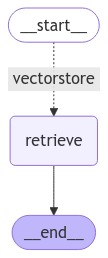

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
from pprint import pprint

# Run
inputs = {
    "question": "What is love?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")



---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'


In [31]:
value

{'question': 'What is love?',
 'documents': [Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the tru

In [32]:
value['documents']

[Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the truth. \n\nThis verse highlights the enduring a